# Random Forest Decision Tree

## Imports

In [5]:
import pandas as pd

In [6]:
# training df 
df_train = pd.read_csv('../../data/train/customer_churn_dataset-training-clean.csv')
#test df 
df_test = pd.read_csv('../../data/test/customer_churn_dataset-testing-clean.csv')

## Splitting Train and Test

In [7]:
# training data setting fitting variables and predictor
X_train = df_train[['age', 'gender', 'tenure', 'usage_frequency', 'support_calls',
       'payment_delay', 'subscription_type', 'contract_length', 'total_spend',
       'last_interaction']]
y_train = df_train['churn']

# test data setting fitting variables and predictor
X_test = df_test[['age', 'gender', 'tenure', 'usage_frequency', 'support_calls',
       'payment_delay', 'subscription_type', 'contract_length', 'total_spend',
       'last_interaction']]
y_test = df_test['churn']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(353644, 10)
(151562, 10)
(353644,)
(151562,)


## Fitting Random Forest Classifier

In [8]:
from sklearn.ensemble import RandomForestClassifier

rfC = RandomForestClassifier(max_depth=3, class_weight='balanced', random_state=42)
rfC.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=42)

## (Baseline) Training Metrics

In [9]:
from sklearn.model_selection import cross_val_score
rfC_train_cv_scores = cross_val_score(rfC, X_train, y_train, cv=5)
print("Cross-validation scores:", rfC_train_cv_scores)

Cross-validation scores: [0.90325043 0.90358976 0.9022466  0.90366045 0.90452155]


In [10]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_train = rfC.predict(X_train)
print(classification_report(y_train, y_pred_train))
print(confusion_matrix(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89    157300
           1       0.90      0.93      0.91    196344

    accuracy                           0.90    353644
   macro avg       0.90      0.90      0.90    353644
weighted avg       0.90      0.90      0.90    353644

[[136200  21100]
 [ 13001 183343]]


## (Baseline) Testing Metrics 

In [11]:
rfC_test_cv_scores = cross_val_score(rfC, X_test, y_test, cv=5)
print("Cross-validation scores:", rfC_test_cv_scores)
rfC_test_score = rfC.score(X_test, y_test)
print("Test score:", rfC_test_score)

Cross-validation scores: [0.90492528 0.90419952 0.90515307 0.90413038 0.89766429]
Test score: 0.9033860730262203


In [12]:
y_pred = rfC.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89     67414
           1       0.90      0.93      0.91     84148

    accuracy                           0.90    151562
   macro avg       0.90      0.90      0.90    151562
weighted avg       0.90      0.90      0.90    151562

[[58390  9024]
 [ 5619 78529]]


## HyperParams GridSearch

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [19]:
pipe = Pipeline(steps=[
    ('scaler', None),
    ('estimator', RandomForestClassifier(class_weight='balanced')),  
])

params = {
    'estimator__n_estimators':[100, 150],
    'estimator__max_depth':[2,3,4],
    'estimator__min_samples_split':[2, 5, 7],
    'estimator__min_samples_leaf': [1, 2, 4],
}

rfC_gs = GridSearchCV(pipe, params, scoring='accuracy', cv=3, verbose=3)
rfC_gs.fit(X_train, y_train)
print('best estimator', rfC_gs.best_estimator_)
print('best params', rfC_gs.best_params_)
print('best score', rfC_gs.best_score_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.868 total time=   4.2s
[CV 2/3] END estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.858 total time=   4.0s
[CV 3/3] END estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.870 total time=   4.0s
[CV 1/3] END estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=150;, score=0.881 total time=   6.1s
[CV 2/3] END estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=150;, score=0.881 total time=   6.0s
[CV 3/3] END estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=150;, sco

In [ ]:
y_pred = rfC_gs.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# slight overfitting apparent, compared to previous model in test.

              precision    recall  f1-score   support

           0       0.90      0.87      0.88     67414
           1       0.90      0.92      0.91     84148

    accuracy                           0.90    151562
   macro avg       0.90      0.90      0.90    151562
weighted avg       0.90      0.90      0.90    151562

[[58510  8904]
 [ 6546 77602]]


## HyperParams RandomSearch

In [23]:
from sklearn.model_selection import RandomizedSearchCV


In [25]:
params = {
    'estimator__n_estimators': [100, 200, 500],
    'estimator__max_depth': [3, 5, 10, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 5],
    'estimator__max_features': ['sqrt', 'log2', None]
}

rfC_rs = RandomizedSearchCV(pipe, params, scoring='roc_auc', n_iter=20, cv=3, n_jobs=-1, random_state=42, verbose=3)
rfC_rs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 2/3] END estimator__max_depth=5, estimator__max_features=log2, estimator__min_samples_leaf=5, estimator__min_samples_split=10, estimator__n_estimators=100;, score=0.948 total time=  15.2s
[CV 3/3] END estimator__max_depth=5, estimator__max_features=log2, estimator__min_samples_leaf=5, estimator__min_samples_split=10, estimator__n_estimators=100;, score=0.950 total time=  15.4s
[CV 2/3] END estimator__max_depth=5, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.950 total time=  15.3s
[CV 1/3] END estimator__max_depth=5, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.947 total time=  15.5s
[CV 3/3] END estimator__max_depth=5, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.949 t

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/3] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500;, score=0.952 total time= 2.2min
[CV 2/3] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500;, score=0.954 total time= 2.2min
[CV 3/3] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500;, score=0.954 total time= 2.2min
[CV 1/3] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500;, score=0.952 total time= 2.2min
[CV 2/3] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500;, score=0.954 total time= 2.2min
[CV 1/3] END estimator__max_depth=5, 

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', None),
                                             ('estimator',
                                              RandomForestClassifier(class_weight='balanced'))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'estimator__max_depth': [3, 5, 10,
                                                                 None],
                                        'estimator__max_features': ['sqrt',
                                                                    'log2',
                                                                    None],
                                        'estimator__min_samples_leaf': [1, 2,
                                                                        5],
                                        'estimator__min_samples_split': [2, 5,
                                                                         10],
                                        'estimator__n_estimators': [100, 200,
                                                                    500]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [27]:
print('best random cv estimator', rfC_rs.best_estimator_)
print('best random cv roc_auc score', rfC_rs.best_score_)
print('best random cv params' , rfC_rs.best_params_)


best random cv estimator Pipeline(steps=[('scaler', None),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=5))])
best random cv roc_auc score 0.9532966765460745
best random cv params {'estimator__n_estimators': 100, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 5, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 10}


In [28]:
y_pred = rfC_rs.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.86      0.92     67414
           1       0.90      0.99      0.94     84148

    accuracy                           0.93    151562
   macro avg       0.94      0.92      0.93    151562
weighted avg       0.93      0.93      0.93    151562

[[58005  9409]
 [ 1165 82983]]


             Feature  Importance
4      support_calls    0.373550
8        total_spend    0.237543
5      payment_delay    0.167185
7    contract_length    0.105340
0                age    0.084263
1             gender    0.015268
9   last_interaction    0.014348
2             tenure    0.001502
3    usage_frequency    0.000995
6  subscription_type    0.000006


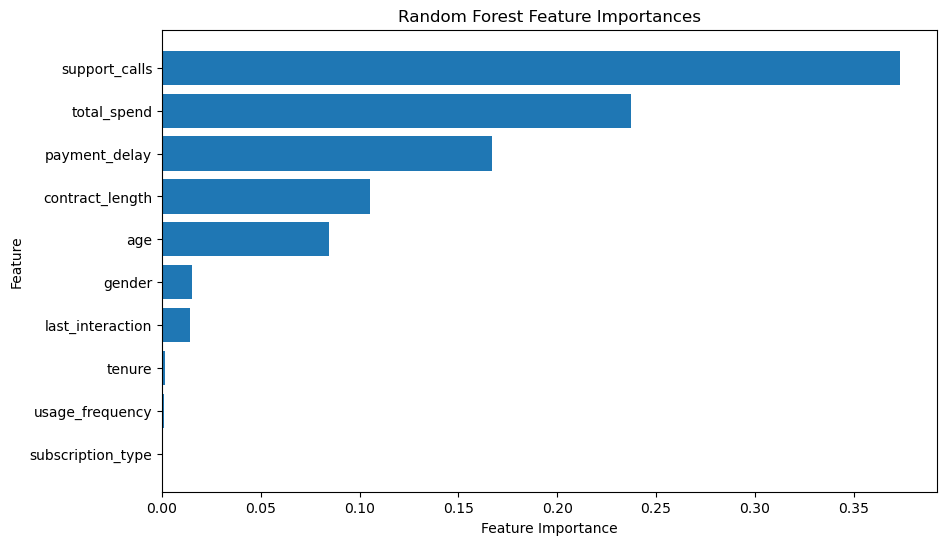

In [32]:
import matplotlib.pyplot as plt

# Access the best estimator's RandomForestClassifier
best_rf = rfC_gs.best_estimator_.named_steps['estimator']

# Get feature importances
importances = best_rf.feature_importances_

# Map to feature names
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 features
print(feature_importance_df.head(10))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.show()



